In [1]:
import re

# Load the book's text
with open('data/TKMBFullBook.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [2]:
chapters = re.split(r'Chapter \d+', text)
if chapters[0].strip() == "":
    chapters.pop(0) # Remove the empty string before the first chapter

In [3]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

def sentence_chunks(text, tokenizer, max_tokens=450, overlap_tokens=60):
    """
    Greedy pack sentences into chunks under max_tokens using the model tokenizer.
    Adds a small sentence-level overlap between adjacent chunks using tokens.
    """
    sents = sent_tokenize(text)
    chunks = []
    current = []
    current_tokens = 0

    def tok_len(t):
        return len(tokenizer.tokenize(t))

    i = 0
    while i < len(sents):
        s = sents[i]
        s_tokens = tok_len(s)
        if s_tokens > max_tokens:
            # Very long sentence: hard split by words as a rare fallback
            words = s.split()
            # keep ~max_tokens-10 tokens margin when splitting
            step = max(1, int(len(words) * (max_tokens / (s_tokens + 1e-9))))
            for wstart in range(0, len(words), step):
                piece = " ".join(words[wstart:wstart+step])
                chunks.append(piece)
            i += 1
            current, current_tokens = [], 0
            continue

        if current_tokens + s_tokens <= max_tokens:
            current.append(s)
            current_tokens += s_tokens
            i += 1
        else:
            # finalize current chunk
            if current:
                chunk_text = " ".join(current)
                chunks.append(chunk_text)

                # build overlap buffer from the end of current
                if overlap_tokens > 0:
                    back = []
                    back_tokens = 0
                    for sent in reversed(current):
                        tl = tok_len(sent)
                        if back_tokens + tl > overlap_tokens:
                            break
                        back.append(sent)
                        back_tokens += tl
                    current = list(reversed(back))
                    current_tokens = sum(tok_len(x) for x in current)
                else:
                    current, current_tokens = [], 0
            else:
                # edge case: single sentence larger than budget handled above
                i += 1

    if current:
        chunks.append(" ".join(current))

    return chunks


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\salij\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
from sentence_transformers import SparseEncoder, SimilarityFunction

model = SparseEncoder(
    "naver/splade-cocondenser-ensembledistil"
    #similarity_fn_name=SimilarityFunction.COSINE,
)

W0819 18:27:24.190000 64320 torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


modules.json:   0%|          | 0.00/274 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/274 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/670 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

In [5]:
tokenizer = model.tokenizer

In [6]:
all_chunks = []
for chap_num, chap_text in enumerate(chapters, start=1):
    for i, chunk in enumerate(sentence_chunks(chap_text, tokenizer,
                                              max_tokens=450, overlap_tokens=60), start=1):
        all_chunks.append({
            "chapter": chap_num,
            "chunk_id": f"{chap_num}_{i}",
            "text": chunk
        })

In [46]:
print(f"Total chunks created: {len(all_chunks)}")
print(f"Example chunk: {all_chunks[72]}")

Total chunks created: 369
Example chunk: {'chapter': 7, 'chunk_id': '7_1', 'text': '\n Jem stayed moody and silent for a week. As Atticus had once advised me to do, I \ntried to climb into Jem’s skin and walk around in it: if I had gone alone to the \nRadley Place at two in the morning, my funeral would have been held the next \nafternoon. So I left Jem alone and tried not to bother him. School started. The second grade was as bad as the first, only worse—they still \nflashed cards at you and wouldn’t let you read or write. Miss Caroline’s progress \nnext door could be estimated by the frequency of laughter; however, the usual \ncrew had flunked the first grade again, and were helpful in keeping order. The \nonly thing good about the second grade was that this year I had to stay as late as \nJem, and we usually walked home together at three o’clock. One afternoon when we were crossing the schoolyard toward home, Jem suddenly \nsaid: “There’s something I didn’t tell you.”\n As this was 

In [15]:
texts = [chunk['text'] for chunk in all_chunks]
embeddings = model.encode(texts, convert_to_tensor=True, show_progress_bar=True, batch_size=32)

Batches: 100%|██████████| 12/12 [01:30<00:00,  7.55s/it]


In [16]:
embeddings[1]  # Example to show the embedding of the second chunk

tensor(indices=tensor([[ 1005,  1055,  1521,  2001,  2002,  2006,  2010,  2015,
                         2016,  2018,  2020,  2026,  2027,  2031,  2037,  2056,
                         2061,  2082,  2089,  2093,  2110,  2138,  2141,  2148,
                         2150,  2155,  2158,  2160,  2167,  2171,  2173,  2210,
                         2221,  2237,  2239,  2240,  2253,  2264,  2269,  2271,
                         2273,  2287,  2299,  2314,  2315,  2318,  2320,  2331,
                         2333,  2351,  2352,  2358,  2359,  2375,  2424,  2436,
                         2438,  2444,  2455,  2466,  2479,  2496,  2511,  2513,
                         2529,  2542,  2562,  2563,  2564,  2567,  2604,  2631,
                         2632,  2661,  2682,  2684,  2709,  2722,  2743,  2815,
                         2817,  2835,  2905,  2945,  2973,  2990,  2994,  3002,
                         3008,  3039,  3060,  3079,  3182,  3191,  3210,  3218,
                         3256,  3268,  3

In [18]:
#Shape of embeddings
print(f"Number of embeddings: {len(embeddings)}")
print(f"Embedding dimension: {len(embeddings[0])}")

Number of embeddings: 369
Embedding dimension: 30522


In [68]:
embeddings[0]

tensor(indices=tensor([[ 1045,  1997,  2001,  2002,  2010,  2012,  2013,  2018,
                         2020,  2021,  2025,  2026,  2031,  2032,  2034,  2039,
                         2040,  2041,  2043,  2052,  2055,  2056,  2057,  2061,
                         2065,  2067,  2077,  2081,  2084,  2086,  2094,  2106,
                         2108,  2113,  2119,  2121,  2126,  2131,  2134,  2138,
                         2140,  2141,  2146,  2147,  2148,  2150,  2155,  2157,
                         2158,  2170,  2176,  2187,  2192,  2196,  2198,  2209,
                         2214,  2217,  2220,  2224,  2234,  2236,  2253,  2256,
                         2257,  2269,  2271,  2272,  2277,  2287,  2288,  2298,
                         2299,  2318,  2347,  2351,  2354,  2359,  2360,  2365,
                         2370,  2374,  2377,  2394,  2398,  2404,  2408,  2409,
                         2410,  2428,  2448,  2460,  2466,  2499,  2501,  2518,
                         2521,  2545,  2

LLM To Query

In [57]:
import openai
from openai import OpenAI
import os

#  OpenAI API key

client = OpenAI(api_key = os.environ.get("OPENAI_API_KEY")) #Using environmental variable

#generate text
def generate_text(prompt: str) -> str:
    """Generates text using the OpenAI API based on the provided prompt."""
    
    # Make the API call
    response = client.chat.completions.create(
        model="gpt-4.1-mini",  
        messages=[{"role": "system", "content": "You are a creative short story writer who writes stories in a specified book style (To Kill a Mockingbird) and answer questions based on it."},
                  {"role": "user", "content": prompt}],
        temperature=0.7,  # Adjust temperature for creativity
    )
    
    return response.choices[0].message.content.strip()

In [58]:
generated_text = generate_text("what was happening to Jem?")
print(generated_text)

In the style of *To Kill a Mockingbird*:

Jem was changing. He was growing up, though sometimes it seemed like a slow, crooked path that led him away from the boy we once knew. His limbs stretched awkwardly, and his voice hovered between a boy’s high pitch and a man’s deeper tone. But it wasn’t just his body that was shifting; Jem’s thoughts were becoming more complicated, tangled in the harsh truths of Maycomb’s world. He wrestled with what he saw—the unfairness, the prejudice, and the quiet courage it took to stand up against them. Sometimes, he’d sit silently, staring off into the distance, burdened by things too heavy for a child’s shoulders. And yet, beneath it all, Jem held onto a flicker of hope, the same hope Atticus had taught us to carry, that someday, things might be different.


In [59]:

import torch
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity  # works with sparse CSR

def torch_sparse_to_csr(sp_t: torch.Tensor, vocab_size: int) -> csr_matrix:
    sp_t = sp_t.coalesce().cpu()
    idx = sp_t.indices()        # [2, nnz]
    vals = sp_t.values().numpy()
    rows, cols = idx[0].numpy(), idx[1].numpy()
    # build a single-row CSR, then stack later
    return csr_matrix((vals, (rows, cols)), shape=(sp_t.size(0), vocab_size))

# Build CSR matrix for all documents
V = embeddings.size(1)
rows, cols, data, indptr = [], [], [], [0]
for i in range(embeddings.size(0)):
    e = embeddings[i].coalesce()
    indices = e.indices().cpu().numpy()
    # If indices has shape (1, nnz), use indices[0], else indices[1]
    if indices.shape[0] == 1:
        c = indices[0]
    else:
        c = indices[1]
    v = e.values().cpu().numpy()
    cols.append(c)
    data.append(v)
    indptr.append(indptr[-1] + len(v))

cols = np.concatenate(cols)
data = np.concatenate(data)
rows = np.repeat(np.arange(len(all_chunks)), np.diff(np.array(indptr)))
X = csr_matrix((data, (rows, cols)), shape=(len(all_chunks), V))

# Optional: L2-normalize rows to use cosine as dot
from sklearn.preprocessing import normalize
X = normalize(X, norm='l2', copy=False)

# Query time
def splade_encode_query(q: str) -> csr_matrix:
    qv = model.encode([q], convert_to_tensor=True)[0].coalesce()
    indices = qv.indices().cpu().numpy()
    # If indices has shape (1, nnz), use indices[0], else indices[1]
    if indices.shape[0] == 1:
        qc = indices[0]
    else:
        qc = indices[1]
    qd = qv.values().cpu().numpy()
    q_csr = csr_matrix((qd, (np.zeros_like(qc), qc)), shape=(1, V))
    return normalize(q_csr, norm='l2', copy=False)


#q_csr = splade_encode_query("That summer in Manchester was unlike any other. The city, usually cloaked in grey skies and drizzle, wore a rare, golden warmth that seemed almost borrowed from a storybook. I was ten, navigating the cobbled streets with Jem and Scout’s spirit in my heart, though our playground was Hulme and not Maycomb.Our days were spent in the shadow of red-brick terraces, where the scent of freshly baked pies mingled with the distant hum of trams. Mr. Thompson, the elderly man from down the street, watched us from his window, much like Atticus did, with a quiet kindness that never needed words. He told stories of the cotton mills and the war, weaving history into our summer like the pages of a well-loved book. One afternoon, we found a stray dog, scruffy and trembling beneath an old lamppost. We named him Boo, after the mysterious neighbor who never left his house. Taking care of Boo felt like a secret rebellion against the harshness of the world outside our doorstep.That summer taught me about kindness, courage, and the beauty hidden in ordinary places — lessons as enduring as any told beneath the Southern sun. Manchester’s streets became my Maycomb, and its people, my family.")
#q_csr = splade_encode_query("Jem becomes moody and silent for about a week because he is growing up and dealing with the confusing changes of adolescence. Scout notices this shift and doesn’t fully understand it, but Atticus explains to her that Jem is simply becoming a young man and that she’ll just need to be patient with him. This period of moodiness is Harper Lee’s way of showing Jem’s transition from childhood into maturity—he is starting to think more deeply about things, pull away from childish games, and sometimes withdraw into himself.")
q_csr = splade_encode_query(generated_text)

scores = (q_csr @ X.T).toarray()[0]         # fast sparse matmul
topk = scores.argsort()[::-1][:10]
results = [all_chunks[i] | {"score": float(scores[i])} for i in topk]

In [60]:
print("Query CSR matrix:")
print(q_csr)

Query CSR matrix:
  (0, 1005)	0.012295257300138474
  (0, 1008)	0.0409386046230793
  (0, 1012)	0.009013977833092213
  (0, 1037)	0.011286899447441101
  (0, 1055)	0.03322393074631691
  (0, 2000)	0.07795343548059464
  (0, 2001)	0.05067635700106621
  (0, 2002)	0.07841834425926208
  (0, 2010)	0.09610572457313538
  (0, 2013)	0.0022336519323289394
  (0, 2018)	0.060774944722652435
  (0, 2021)	0.014614556916058064
  (0, 2032)	0.03924471512436867
  (0, 2039)	0.09199632704257965
  (0, 2052)	0.012760480865836143
  (0, 2054)	0.020055804401636124
  (0, 2055)	0.014523125253617764
  (0, 2056)	0.060461413115262985
  (0, 2057)	0.0025204778648912907
  (0, 2062)	0.023053372278809547
  (0, 2066)	0.057827599346637726
  (0, 2082)	0.012462056241929531
  (0, 2088)	0.05713813379406929
  (0, 2089)	0.1428804099559784
  (0, 2113)	0.002179302042350173
  :	:
  (0, 15274)	0.16035139560699463
  (0, 15291)	0.02513408102095127
  (0, 15360)	0.01581938937306404
  (0, 15571)	0.12617965042591095
  (0, 16133)	0.02778964303433

In [35]:
print("Top 10 results:")
for result in results:
    print(f" - {result['text']} (score: {result['score']})")

Top 10 results:
 - Maybe someday we would see him. I imagined how it would be: when it happened, he’d just be sitting in the swing 
when I came along. “Hidy do, Mr. Arthur,” I would say, as if I had said it every 
afternoon of my life. “Evening, Jean Louise,” he would say, as if he had said it 
every afternoon of my life, “right pretty spell we’re having, isn’t it?” “Yes sir, 
right pretty,” I would say, and go on. It was only a fantasy. We would never see him. He probably did go out when the 
moon was down and gaze upon Miss Stephanie Crawford. I’d have picked 
somebody else to look at, but that was his business. He would never gaze at us. “You aren’t starting that again, are you?” said Atticus one night, when I expressed 
a stray desire just to have one good look at Boo Radley before I died. “If you are, 
I’ll tell you right now: stop it. I’m too old to go chasing you off the Radley 
property. Besides, it’s dangerous. You might get shot. You know Mr. Nathan 
shoots at every shadow he

In [61]:
print("Top 10 results:")
for result in results:
    print(f"Chapter {result['chapter']} | Chunk {result['chunk_id']} | Score: {result['score']:.3f}")
    print(result['text'])
    print("---")

Top 10 results:
Chapter 30 | Chunk 30_3 | Score: 0.284
Finch, do you think Jem killed Bob Ewell? Do you think that?”
 “You heard what Scout said, there’s no doubt about it. She said Jem got up and 
yanked him off her—he probably got hold of Ewell’s knife somehow in the 
dark… we’ll find out tomorrow.”
 “Mis-ter Finch, hold on,” said Mr. Tate. “Jem never stabbed Bob Ewell.”
 Atticus was silent for a moment. He looked at Mr. Tate as if he appreciated what 
he said. But Atticus shook his head. “Heck, it’s mighty kind of you and I know you’re doing it from that good heart of 
yours, but don’t start anything like that.”
 Mr. Tate got up and went to the edge of the porch. He spat into the shrubbery, 
then thrust his hands into his hip pockets and faced Atticus. “Like what?” he said. “I’m sorry if I spoke sharply, Heck,” Atticus said simply, “but nobody’s hushing 
this up. I don’t live that way.”
 “Nobody’s gonna hush anything up, Mr. Finch.”
 Mr. Tate’s voice was quiet, but his boots were pl

Reranking with Cross Encoder

In [62]:
from sentence_transformers import CrossEncoder

# Load a light reranker (fast, works on CPU)
reranker = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2", max_length=512)

def rerank(query, candidates, top_k=10, batch_size=16):
    """
    Rerank retrieved passages using a cross-encoder.

    Args:
        query (str): User's query string.
        candidates (list[dict]): List of dicts with at least {"text": ...}.
        top_k (int): How many final results to return.
        batch_size (int): Batch size for reranker inference.

    Returns:
        list[dict]: Top-k candidate dicts with "rerank_score".
    """
    # Build query-passage pairs
    pairs = [(query, c["text"]) for c in candidates]

    # Score with cross-encoder
    scores = reranker.predict(pairs, batch_size=batch_size)

    # Attach scores
    for c, s in zip(candidates, scores):
        c["rerank_score"] = float(s)

    # Sort by rerank_score
    ranked = sorted(candidates, key=lambda x: x["rerank_score"], reverse=True)
    return ranked[:top_k]


In [64]:
# Step 1: SPLADE sparse retrieval

#q_csr = splade_encode_query("That summer in Manchester was unlike any other. The city, usually cloaked in grey skies and drizzle, wore a rare, golden warmth that seemed almost borrowed from a storybook. I was ten, navigating the cobbled streets with Jem and Scout’s spirit in my heart, though our playground was Hulme and not Maycomb.Our days were spent in the shadow of red-brick terraces, where the scent of freshly baked pies mingled with the distant hum of trams. Mr. Thompson, the elderly man from down the street, watched us from his window, much like Atticus did, with a quiet kindness that never needed words. He told stories of the cotton mills and the war, weaving history into our summer like the pages of a well-loved book. One afternoon, we found a stray dog, scruffy and trembling beneath an old lamppost. We named him Boo, after the mysterious neighbor who never left his house. Taking care of Boo felt like a secret rebellion against the harshness of the world outside our doorstep.That summer taught me about kindness, courage, and the beauty hidden in ordinary places — lessons as enduring as any told beneath the Southern sun. Manchester’s streets became my Maycomb, and its people, my family.")
#q_csr = splade_encode_query("The proposal came suddenly, in the way summer promises often do—bright, impulsive, and quickly forgotten. At first, it sounded like a vow for life: a declaration that there would never be anyone else, that love had already been found and secured. But as the days passed, the words faded, replaced by neglect.")
q_csr = splade_encode_query(generated_text)

scores = (q_csr @ X.T).toarray()[0]

# Step 2: Take top-100 candidates
topk_idx = scores.argsort()[::-1][:100]
candidates = [all_chunks[i] | {"splade_score": float(scores[i])} for i in topk_idx]

# Step 3: Rerank with cross-encoder
final = rerank(generated_text, candidates, top_k=10)

# Step 4: Inspect results
for r in final:
    print(r["chapter"], r["chunk_id"], r["rerank_score"])
    print(r["text"][:150], "...\n")


10 10_2 -0.5673258900642395
Francis Hancock, 
for example, knew that. When he gave us our air-rifles Atticus wouldn’t teach us to shoot. Uncle Jack 
instructed us in the rudiment ...

10 10_8 -0.7293957471847534
“We better wait, Mr. Finch. They usually go in a straight line, but you never can 
tell. He might follow the curve—hope he does or he’ll go straight i ...

21 21_6 -0.8571988940238953
I toyed with the idea of asking 
everyone below to concentrate on setting Tom Robinson free, but thought if they 
were as tired as I, it wouldn’t work ...

12 12_1 -1.0978748798370361

 Jem was twelve. He was difficult to live with, inconsistent, moody. His appetite 
was appalling, and he told me so many times to stop pestering him  ...

14 14_8 -1.5734879970550537
He walked the rest of the way. “How’d you get here?” asked Jem. He had taken thirteen dollars from his mother’s purse, caught the nine o’clock 
from M ...

10 10_12 -1.6353799104690552
Jem became vaguely articulate: “‘d you see him, Sco

In [ ]:
# IR evaluation utilities
from typing import List, Set, Iterable, Dict
import math


def precision_at_k(y_true: Set, y_pred: List, k: int) -> float:
    if k <= 0:
        return 0.0
    top_k = y_pred[:k]
    hits = sum(1 for d in top_k if d in y_true)
    return hits / k


def recall_at_k(y_true: Set, y_pred: List, k: int) -> float:
    if not y_true:
        return 0.0
    top_k = y_pred[:k]
    hits = sum(1 for d in top_k if d in y_true)
    return hits / len(y_true)


def precision_at_r(y_true: Set, y_pred: List) -> float:
    # Precision at R = len(y_true)
    R = len(y_true)
    if R == 0:
        return 0.0
    return precision_at_k(y_true, y_pred, R)


def average_precision(y_true: Set, y_pred: List) -> float:
    if not y_true:
        return 0.0
    hit_count = 0
    sum_prec = 0.0
    for i, d in enumerate(y_pred, start=1):
        if d in y_true:
            hit_count += 1
            sum_prec += hit_count / i
    return sum_prec / len(y_true)


def mean_average_precision(all_y_true: Iterable[Set], all_y_pred: Iterable[List]) -> float:
    ap_values = [average_precision(y_true, y_pred) for y_true, y_pred in zip(all_y_true, all_y_pred)]
    if not ap_values:
        return 0.0
    return sum(ap_values) / len(ap_values)


def reciprocal_rank(y_true: Set, y_pred: List) -> float:
    for i, d in enumerate(y_pred, start=1):
        if d in y_true:
            return 1.0 / i
    return 0.0


def mean_reciprocal_rank(all_y_true: Iterable[Set], all_y_pred: Iterable[List]) -> float:
    rr_values = [reciprocal_rank(y_true, y_pred) for y_true, y_pred in zip(all_y_true, all_y_pred)]
    if not rr_values:
        return 0.0
    return sum(rr_values) / len(rr_values)


def dcg_at_k(y_true: Set, y_pred: List, k: int) -> float:
    dcg = 0.0
    for i, d in enumerate(y_pred[:k], start=1):
        rel = 1 if d in y_true else 0
        if rel:
            dcg += (2 ** rel - 1) / math.log2(i + 1)
    return dcg


def idcg_at_k(y_true: Set, k: int) -> float:
    # ideal DCG for binary relevance: put all relevant docs at top
    rels = min(len(y_true), k)
    idcg = 0.0
    for i in range(1, rels + 1):
        idcg += (2 ** 1 - 1) / math.log2(i + 1)
    return idcg


def ndcg_at_k(y_true: Set, y_pred: List, k: int) -> float:
    idcg = idcg_at_k(y_true, k)
    if idcg == 0:
        return 0.0
    return dcg_at_k(y_true, y_pred, k) / idcg

def accuracy(y_true: Set, y_pred: List) -> float:
    if not y_true:
        return 0.0
    correct = sum(1 for d in y_pred if d in y_true)
    return correct / len(y_true)

def evaluate_all(
    all_y_true: Iterable[Set],
    all_y_pred: Iterable[List],
    ks: List[int] = [1, 3, 5, 10]
) -> Dict:
    """
    Compute common IR metrics across queries.
    Inputs:
      - all_y_true: iterable of sets (relevant doc ids) per query
      - all_y_pred: iterable of lists (ranked doc ids) per query
      - ks: list of K values to compute Precision@K and nDCG@K

    Returns a dictionary with aggregated metrics.
    """
    all_y_true = list(all_y_true)
    all_y_pred = list(all_y_pred)
    assert len(all_y_true) == len(all_y_pred), "y_true and y_pred must have same length"

    results = {}

    # Precision@k and Recall@k averages
    for k in ks:
        p_at_k = [precision_at_k(y_true, y_pred, k) for y_true, y_pred in zip(all_y_true, all_y_pred)]
        r_at_k = [recall_at_k(y_true, y_pred, k) for y_true, y_pred in zip(all_y_true, all_y_pred)]
        ndcg_k = [ndcg_at_k(y_true, y_pred, k) for y_true, y_pred in zip(all_y_true, all_y_pred)]
        results[f'P@{k}'] = sum(p_at_k) / len(p_at_k) if p_at_k else 0.0
        results[f'R@{k}'] = sum(r_at_k) / len(r_at_k) if r_at_k else 0.0
        results[f'nDCG@{k}'] = sum(ndcg_k) / len(ndcg_k) if ndcg_k else 0.0

    # Precision@R (averaged across queries)
    p_at_r_list = [precision_at_r(y_true, y_pred) for y_true, y_pred in zip(all_y_true, all_y_pred)]
    results['P@R'] = sum(p_at_r_list) / len(p_at_r_list) if p_at_r_list else 0.0

    # MAP and MRR
    results['MAP'] = mean_average_precision(all_y_true, all_y_pred)
    results['MRR'] = mean_reciprocal_rank(all_y_true, all_y_pred)

    return results


# --- Minimal usage example ---
# Suppose doc ids are integers. For real evaluation supply: 
# - `all_y_true`: list of sets ({relevant_doc_ids}) for each query
# - `all_y_pred`: list of ranked lists ([doc_id1, doc_id2, ...]) for each query

y_true = {"7_1", "10_12", "12_1"}  # Example relevant doc ids for a single query
y_pred = [r["chunk_id"] for r in final]  # final is your reranked list

# Wrap in lists for single-query evaluation
#print('Example evaluation on dummy data:')
print(evaluate_all([y_true], [y_pred], ks=[3,5,10]))

# End of evaluation utilities


{'P@3': 0.0, 'R@3': 0.0, 'nDCG@3': 0.0, 'P@5': 0.2, 'R@5': 0.3333333333333333, 'nDCG@5': 0.20210734650054757, 'P@10': 0.2, 'R@10': 0.6666666666666666, 'nDCG@10': 0.36926780146674987, 'P@R': 0.0, 'MAP': 0.19444444444444442, 'MRR': 0.25}


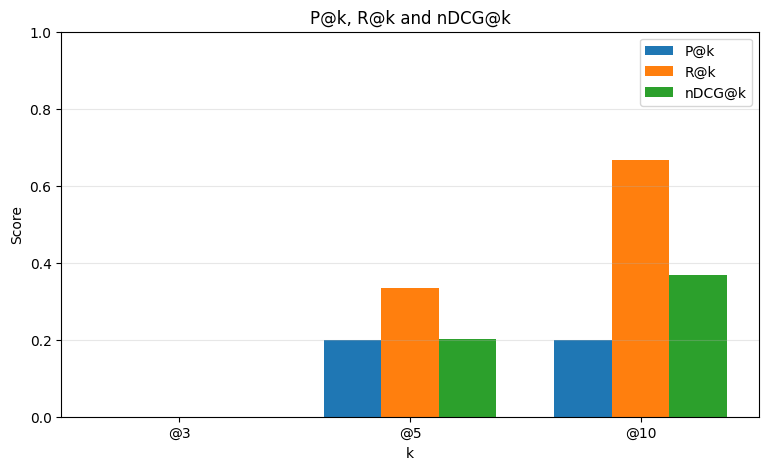

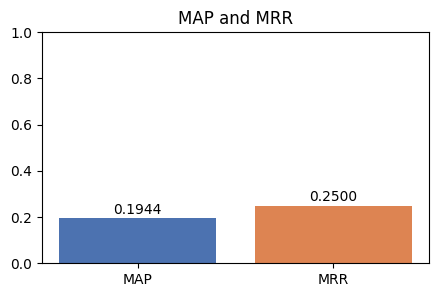

Numeric results:
P@3: 0.0000  R@3: 0.0000  nDCG@3: 0.0000
P@5: 0.2000  R@5: 0.3333  nDCG@5: 0.2021
P@10: 0.2000  R@10: 0.6667  nDCG@10: 0.3693
MAP: 0.1944  MRR: 0.2500


In [70]:
# Plot evaluation results (P@k, R@k, nDCG@k, MAP, MRR)
import matplotlib.pyplot as plt

# Ensure evaluation data exists
try:
    # If evaluate_all was run earlier we may already have a results dict; otherwise compute now
    if 'y_true' in globals() and 'y_pred' in globals():
        results = evaluate_all([y_true], [y_pred], ks=[3,5,10])
    else:
        raise NameError('y_true or y_pred not found - run the rerank/evaluation cell first')
except Exception as e:
    print('Error preparing evaluation metrics:', e)
    raise

# Collect ks present in results (P@k keys)
ks = sorted([int(k.split('@')[1]) for k in results.keys() if k.startswith('P@') and k.split('@')[1].isdigit()])

p_vals = [results.get(f'P@{k}', 0.0) for k in ks]
r_vals = [results.get(f'R@{k}', 0.0) for k in ks]
ndcg_vals = [results.get(f'nDCG@{k}', 0.0) for k in ks]

# MAP and MRR
map_val = results.get('MAP', results.get('MAP', 0.0))
mrr_val = results.get('MRR', results.get('MRR', 0.0))

# Plot P@k, R@k, nDCG@k grouped
x = range(len(ks))
width = 0.25
plt.figure(figsize=(9,5))
plt.bar([i - width for i in x], p_vals, width=width, label='P@k')
plt.bar(x, r_vals, width=width, label='R@k')
plt.bar([i + width for i in x], ndcg_vals, width=width, label='nDCG@k')
plt.xticks(x, [f'@{k}' for k in ks])
plt.ylim(0, 1)
plt.xlabel('k')
plt.ylabel('Score')
plt.title('P@k, R@k and nDCG@k')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

# Plot MAP and MRR
plt.figure(figsize=(5,3))
plt.bar(['MAP','MRR'], [map_val, mrr_val], color=['#4c72b0','#dd8452'])
plt.ylim(0,1)
plt.title('MAP and MRR')
for i, v in enumerate([map_val, mrr_val]):
    plt.text(i, v + 0.02, f'{v:.4f}', ha='center')
plt.show()

# Print numeric results
print('Numeric results:')
for k in ks:
    print(f'P@{k}: {p_vals[ks.index(k)]:.4f}  R@{k}: {r_vals[ks.index(k)]:.4f}  nDCG@{k}: {ndcg_vals[ks.index(k)]:.4f}')
print(f'MAP: {map_val:.4f}  MRR: {mrr_val:.4f}')
